# 이미지 Dataset 만들기 - ImageDataGenerator 와 flow_from_directory 이용
+ 이번 과정도 콘크리트 이미지 데이터를 가지고 DataSet을 만들어 이미지 분류 모델을 만들도록 하겠습니다.
+ DataSet을 만들기 위해 많은 작업(from_tensor_slices, map, cache, batch, shuffle, prefetch)과 라벨 코딩등이 필요합니다.
+ 이런 작업없이 쉽게 Dataset를 만들수 있는ImageDataGenerator 와 flow_from_directory 배워보도록 하겠습니다.
+ 또한, ImageDataGenerator 와 flow_from_directory은 데이터 Augmentation 사용할수 있습니다.

### 학습목차
##### A. ImageDataGenerator 와 flow_from_directory 이용하여 데이터셋 만들기
1. 필요한 라이브러리 임포트
2. 이미지 파일 가져오기 : concrete_image.zip
3. 이미지 파일 하나 읽어 이미지 보기
4. Data Preprocess : ImageDataGenerator 와 flow_from_directory 이용하여 이미지 데이터셋 생성, 라벨링(라벨인코딩,원핫인코딩) 한꺼번에 처리

##### B. 모델링
1. Build Model : Functional API
2. Callback
3. 모델 학습
4. 성능 그래프
5. Predict

## A. ImageDataGenerator 와 flow_from_directory 이용하여 데이터셋 만들기

### 1. 필요한 라이브러리 임포트

In [ ]:
from glob import glob
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 2. 이미지 파일 가져오기 : concrete_image.zip

In [ ]:
# 업로드한 concrete_image.zip 파일 확인
glob('concrete_image.zip')

['concrete_image.zip']

In [ ]:
# 이미지 폴더 생성 및 concrete_image.zip 파일 압축 풀기

if not os.path.exists('IMAGE'):
    os.mkdir('IMAGE')
    !unzip concrete_image.zip -d IMAGE

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: IMAGE/Negative/01002.jpg  
  inflating: IMAGE/Negative/01003.jpg  
  inflating: IMAGE/Negative/01004.jpg  
  inflating: IMAGE/Negative/01005.jpg  
  inflating: IMAGE/Negative/01006.jpg  
  inflating: IMAGE/Negative/01007.jpg  
  inflating: IMAGE/Negative/01008.jpg  
  inflating: IMAGE/Negative/01009.jpg  
  inflating: IMAGE/Negative/01010.jpg  
  inflating: IMAGE/Negative/01011.jpg  
  inflating: IMAGE/Negative/01012.jpg  
  inflating: IMAGE/Negative/01013.jpg  
  inflating: IMAGE/Negative/01014.jpg  
  inflating: IMAGE/Negative/01015.jpg  
  inflating: IMAGE/Negative/01016.jpg  
  inflating: IMAGE/Negative/01017.jpg  
  inflating: IMAGE/Negative/01018.jpg  
  inflating: IMAGE/Negative/01019.jpg  
  inflating: IMAGE/Negative/01020.jpg  
  inflating: IMAGE/Negative/01021.jpg  
  inflating: IMAGE/Negative/01022.jpg  
  inflating: IMAGE/Negative/01023.jpg  
  inflating: IMAGE/Negative/01024.jpg  
  inflating: IMAGE/Negative/01025.jpg  
  in

In [ ]:
# concrete_image Negative 폴더 안의 이지미 갯수
!ls -l ./IMAGE/Negative/ | grep jpg | wc -l

3000


In [ ]:
# concrete_image Positive 폴더 안의 이지미 갯수
!ls -l ./IMAGE/Positive/ | grep jpg | wc -l

3000


### 3.. 이미지 파일 하나 읽어 이미지 보기

In [ ]:
# 이미지 패스 지정
path = './IMAGE/Negative/00001.jpg'

In [ ]:
# 이미지 읽어오기
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)

In [ ]:
# 이미지 shape 확인
image.shape

TensorShape([227, 227, 3])

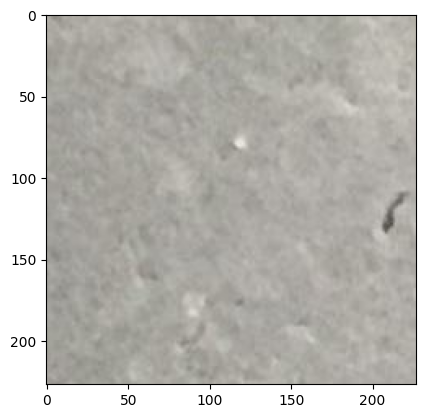

In [ ]:
# 읽어온 Negative 이미지 보기
plt.imshow(image)
plt.show()

### 4. Data Preprocess

### ImageDataGenerator 와 flow_from_directory 이용하여 이미지 데이터셋 생성, 라벨링(라벨인코딩,원핫인코딩) 한꺼번에 처리 할수 있다.
### <font color=red>[조건] IMAGE 폴더 있고 그 아래 각 class별 이름 폴더가 있고 class별 폴더 안에 이미지 파일 있을 경우, 아래 수행합니다.</font>
- class 폴더 이름을 label로 취급
- 이미지 읽어 메모리 올리기
- 이미지 데이터 Augmentation 가능
- class 폴더 이름 label을 One-Hot-Encoding 수행
- 이미지, 라벨 튜플 묶고, shuffle, batch 후 데이터셋 생성


In [ ]:
# Hyperparameter Tunning

num_epochs = 10
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (227, 227, 3)  # 사이즈 확인
num_classes = 2    # Postive , Negative

In [ ]:
# 이미지 증강 시킬때 사용하는 ImageDataGenerator 함수 import
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### ImageDataGenerator 와  flow_from_directory 기능
+ ImageDataGenerator : 이미지 데이터에 대해 증강(augmentation)과 rescaling, validation_split 등의 전처리 기능 수행
+ flow_from_directory : 실제 이미지 데이터 읽고 배치, 셔플하고 labeling 수행 및 데이터셋 생성

In [ ]:
# ImageDataGenerator 이용하여 이미지 증강과 전처리하기
# - 여기서는 data augmentation 하지 않음 : 주석처리했으며 필요하면 주석해체하여 사용하면 됨
# - 1개 IMAGE 폴더로 Train, Test dataset으로 나누어야 되므로 validation_split 사용해야 함
# - validation 데이터 사이즈 입력 : validation_split=0.2 --> train set : valid set = 8 : 2
# - rescaling 수행

image_datagen = ImageDataGenerator(
      rescale=1. / 255,
      validation_split=0.2     # train set : valid set = 8 : 2
#       rotation_range=30,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       shear_range=0.1,
#       zoom_range=0.1,
#       horizontal_flip=True,
#       fill_mode='nearest'
    )

In [ ]:
# ImageDataGenerator.flow_from_directory
# - 이미지 폴더 내의 데이터  읽고 배치 , 셔플하고 labeling 수행
# - 2개 Class에 대한 라벨링(라벨인코딩,원핫인코딩) 수행
# - subset = 'training' --> training_generator 생성
# - subset = 'validation' --> test_generator 생성
# - 수행결과, IMAGE 폴더로 Train 4,800건, Test 1,200건 dataset 만듬

# IMAGE 포더 밑에 .ipynb_checkpoints 폴더 있을경우 폴데 삭제
!rm -rf ./IMAGE/.ipynb_checkpoints

training_generator = image_datagen.flow_from_directory(
    './IMAGE',
    batch_size=batch_size,        # batch_size = 32
    target_size=(227, 227),       # 원하는 출력 사이즈 입력. 데이터 생성후 (227, 227, 3) 변환. 디폴트 color_mode='rgb', 3 채널
    class_mode = 'categorical',   # binary 혹은 categorical
    shuffle = True,
    subset = 'training'           # training 혹은 validation. ImageDataGenerator의 validation_split 사용하므로 subset 지정해야
    )

test_generator = image_datagen.flow_from_directory(
    './IMAGE',
    batch_size=batch_size,
    target_size=(227, 227),       # 원하는 출력 사이즈 입력. 데이터 생성후 (227, 227, 3) 변환. 디폴트 color_mode='rgb', 3 채널
    class_mode = 'categorical',   # binary 혹은 categorical
    shuffle = False,
    subset = 'validation'         # training 혹은 validation. ImageDataGenerator의 validation_split 사용하므로 subset 지정해야
    )

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [ ]:
# Train, test 건수 확인
# batch_size : 32
len(training_generator) * batch_size , len(test_generator) * batch_size

(4800, 1216)

In [ ]:
# class 이름 및 번호 매핑 확인
print(training_generator.class_indices)

{'Negative': 0, 'Positive': 1}


In [ ]:
# 데이터셋에서 1개 가져오기
batch_img, batch_label = next(iter(training_generator))
print(batch_img.shape)    # 32개의 사진 이미지
print(batch_label.shape)  # 32개의 사진에 대한 원핫인코딩된 라벨

(32, 227, 227, 3)
(32, 2)


True Value :  [1. 0.]


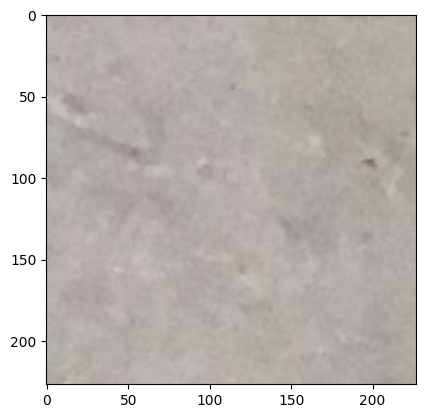

In [ ]:
print('True Value : ', batch_label[0])  # 32개의 사진 이미지중 첫번째 사진의 라벨
plt.imshow(batch_img[0])   # 32개의 사진 이미지중 첫번째 사진 이미지
plt.show()

## B. 모델링

### 1. Build Model

In [ ]:
# Functional API 모델 정의

inputs = tf.keras.layers.Input(input_shape)

net = tf.keras.layers.Conv2D(32, (3, 3), padding='SAME')(inputs)  # 227 X 227 X 32
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(32, (3, 3), padding='SAME')(net)  # 227 X 227 X 32
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(net)  # 113 X 113 X 32
net = tf.keras.layers.Dropout(dropout_rate)(net)

net = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME')(net)  # 113 X 113 X 64
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(64, (3, 3), padding='SAME')(net)  # 113 X 113 X 64
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(net)  # 56 X 56 X 64
net = tf.keras.layers.Dropout(dropout_rate)(net)

net = tf.keras.layers.Flatten()(net)  # 200,704
net = tf.keras.layers.Dense(512)(net)
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Dropout(dropout_rate)(net)
net = tf.keras.layers.Dense(num_classes)(net)
net = tf.keras.layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [ ]:
# Model is the full model w/o custom layers
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])  # Metrics / Accuracy

In [ ]:
model.summary()

Model: "Basic_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 227, 227, 32)      896       
                                                                 
 activation_6 (Activation)   (None, 227, 227, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 227, 227, 32)      9248      
                                                                 
 activation_7 (Activation)   (None, 227, 227, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 113, 113, 32)      0         
 g2D)                                                            
                                                         

### 2. Callback

In [ ]:
# callback : EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# ReduceLROnPlateau : val_loss가 2번 이상 감소되지 않으면 lr * factor = lr 새로운 lr로 변경해서 학습 진행
lrReducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

### 3. 모델학습

In [ ]:
# ImageDataGenerator 와 flow_from_directory 이용하여 데이터 만들었을때 아래와 같이 학습
# val_accuracy 50% 정도 나옴
# num_epochs = 10
# batch_size = 32

history = model.fit(
    training_generator,
    validation_data = test_generator,
    epochs=10,
    batch_size = batch_size,
    callbacks=[es, checkpoint, lrReducer]
)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4917
Epoch 1: val_loss did not improve from 0.69315
150/150 [==============================] - 30s 199ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5023
Epoch 2: val_loss improved from 0.69315 to 0.69315, saving model to my_checkpoint.ckpt
150/150 [==============================] - 39s 257ms/step - loss: 0.6932 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5067
Epoch 3: val_loss did not improve from 0.69315
150/150 [==============================] - 29s 190ms/step - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/30
150/150 [==============================] - ETA: 0s - loss: 0.6932 -

### 4. 성능 그래프

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

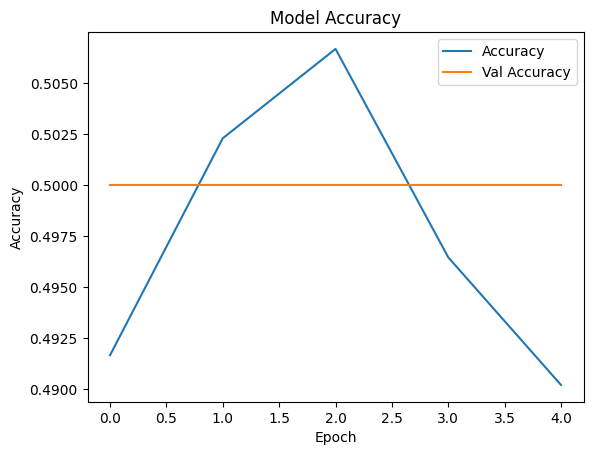

In [ ]:
# 성능 그래프
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

### 5. Predict

In [ ]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인
batch_img, batch_label = next(iter(test_generator))
print(batch_img.shape)
print(batch_label.shape)

(32, 227, 227, 3)
(32, 2)


In [ ]:
# 32개 Test 샘플 이미지 그려보고 예측해 보기

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.reshape(-1,227,227,3))
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img)
    i = i + 1

Output hidden; open in https://colab.research.google.com to view.

## 배운 내용 정리
1. DataSet을 만들기 위해 많은 수작업(파일 읽어오기, Pipeline(map, cache, batch, shuffle, prefetch), 라벨 코딩등) 필요
2. 이런 작업을 imageDataGenerator 와 flow_from_directory 활용하여 쉽게 DataSet을 만들수 있습니다.
3. 폴더명이 class명으로 되어 있다면 ImageDataGenerator 와 flow_from_directory을 잘 사용해서 Dataset을 만들수 있으면 되겠네요.